## Import Packages

In [14]:
import os

import numpy as np
import pandas as pd
import polars as pl
import json

import warnings

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial import ConvexHull

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.neighbors import NearestNeighbors, BallTree
from annoy import AnnoyIndex
import faiss
import hnswlib

import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter(action = 'ignore', category = FutureWarning)
pl.Config.set_tbl_width_chars(150)
pl.Config.set_tbl_rows(1000)
pl.Config.set_tbl_cols(20)

seed          = 7
weight_factor = 5.0

## Import Datasets

In [15]:
df_players  = pl.read_parquet("/mnt/block/data/final_datasets/player_performance.parquet")

with open('/mnt/block/data/final_datasets/player_heatmap_features.json', 'r') as f:
    data = json.load(f)

df_spatial = pl.DataFrame({"id": [entry["playerId"] for entry in data],
                           "spatial_positioning": [entry["features"] for entry in data]
                          })
pd_df      = pd.read_csv("/mnt/block/data/player_data/mapping.csv")

In [16]:
print(df_spatial.columns)
print(df_players.columns)

['id', 'spatial_positioning']
['Id', 'firstName', 'middleName', 'lastName', 'full_name', 'birthDay', 'age', 'weight', 'height', 'foot', 'club', 'currentTeamId', 'national_team', 'currentNationalTeamId', 'country_of_birth', 'city_of_birth', 'country_of_citizenship', 'position', 'Role', 'status', 'market_value_in_eur', 'highest_market_value_in_eur', 'contract_expiration_date', 'agent_name', 'UrlFBref', 'image_url', 'UrlTmarkt', 'TMarketID', 'WyScoutID', 'StatsBombID', 'FBrefID', 'Matches Played', 'Total Shots', 'Accurate Shots', 'Shot Accuracy', 'Goals', 'Shot Conversion', 'Penalties Taken', 'Penalties Scored', 'Penalty Conversion', 'Total Passes', 'Accurate Passes', 'Pass Accuracy', 'Key Passes', 'Assists', 'Run Attempts With Ball', 'Successful Runs With Ball', 'Perc Successful Runs With Ball', 'Crosses', 'Dribbles', 'Free Kick Shots', 'Free Kick Crosses', 'Aerial Duels', 'Aerial Duels Won', 'Perc Aerial Duels Won', 'Ground Defensive duels Won', 'Loose Ball Duels', 'Loose Balls Won', 'P

## Merge Datasets

In [4]:
df = df_players.join(df_spatial, left_on = "Id", right_on = "id", how = "left")

# Rename column to match desired output format
df = df.rename({"spatial_positioning": "spatial"})

columns = [
    'Id', 'age', 'weight', 'height',
    'position', 'Role', 'market_value_in_eur', 'highest_market_value_in_eur', 'contract_expiration_date', 'agent_name',
    'Matches Played', 'Total Shots', 'Accurate Shots', 'Shot Accuracy', 'Goals', 'Shot Conversion', 'Penalties Taken', 'Penalties Scored', 'Penalty Conversion', 'Free Kick Shots',
    'Total Passes', 'Accurate Passes', 'Pass Accuracy', 'Key Passes', 'Assists', 'Crosses', 'Free Kick Crosses', 
    'Run Attempts With Ball', 'Successful Runs With Ball', 'Perc Successful Runs With Ball', 'Dribbles',
    'Aerial Duels', 'Aerial Duels Won', 'Perc Aerial Duels Won', 'Ground Defensive duels Won', 'Loose Ball Duels', 'Loose Balls Won', 'Perc Loose Balls Won',
    'Sliding Tackles', 'Interceptions', 'Clearances', 'Blocks', 'Possession Regained', 'Own Goals',
    'GK Balls Attacked', 'GK Save Attempts', 'GK Successful Save Attempts', 'Perc GK Save Success',
    'spatial'
]

# Reorder columns (ignore missing ones)
df = df.select([col for col in columns if col in df.columns])

# Done
print(df.head())
print(df.columns)
print(df.dtypes)

shape: (5, 49)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬────────┬───────┬───┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ Id  ┆ age ┆ wei ┆ hei ┆ pos ┆ Rol ┆ mar ┆ hig ┆ contra ┆ agent ┆ … ┆ Inter ┆ Clear ┆ Block ┆ Posse ┆ Own   ┆ GK    ┆ GK    ┆ GK    ┆ Perc  ┆ spati │
│ --- ┆ --- ┆ ght ┆ ght ┆ iti ┆ e   ┆ ket ┆ hes ┆ ct_exp ┆ _name ┆   ┆ cepti ┆ ances ┆ s     ┆ ssion ┆ Goals ┆ Balls ┆ Save  ┆ Succe ┆ GK    ┆ al    │
│ i64 ┆ i32 ┆ --- ┆ --- ┆ on  ┆ --- ┆ _va ┆ t_m ┆ iratio ┆ ---   ┆   ┆ ons   ┆ ---   ┆ ---   ┆ Regai ┆ ---   ┆ Attac ┆ Attem ┆ ssful ┆ Save  ┆ ---   │
│     ┆     ┆ str ┆ str ┆ --- ┆ str ┆ lue ┆ ark ┆ n_date ┆ str   ┆   ┆ ---   ┆ i32   ┆ i32   ┆ ned   ┆ i32   ┆ ked   ┆ pts   ┆ Save  ┆ Succe ┆ list[ │
│     ┆     ┆     ┆     ┆ str ┆     ┆ _in ┆ et_ ┆ ---    ┆       ┆   ┆ i32   ┆       ┆       ┆ ---   ┆       ┆ ---   ┆ ---   ┆ Attem ┆ ss    ┆ f64]  │
│     ┆     ┆     ┆     ┆     ┆     ┆ _eu ┆ val ┆ str    ┆       ┆   ┆       ┆ 

## Clean Datasets

In [5]:
role_encoder     = LabelEncoder()
position_encoder = LabelEncoder()

# Convert weight and height to float
df = df.with_columns([pl.col("weight").cast(pl.Float64),
                      pl.col("height").cast(pl.Float64)
                    ])

# Drop incomplete columns
df    = df.drop(['position', 'Role', "market_value_in_eur", "highest_market_value_in_eur", "contract_expiration_date", "agent_name"])
df    = df.filter(pl.col("spatial").is_not_null())

# number of rows with null in the spatial column
print(df.select([pl.col(c).is_null().sum().alias(f"{c}_nulls") for c in df.columns]))

shape: (1, 43)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬────────┬───────┬───┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ Id_ ┆ age ┆ wei ┆ hei ┆ Mat ┆ Tot ┆ Acc ┆ Sho ┆ Goals_ ┆ Shot  ┆ … ┆ Inter ┆ Clear ┆ Block ┆ Posse ┆ Own   ┆ GK    ┆ GK    ┆ GK    ┆ Perc  ┆ spati │
│ nul ┆ _nu ┆ ght ┆ ght ┆ che ┆ al  ┆ ura ┆ t   ┆ nulls  ┆ Conve ┆   ┆ cepti ┆ ances ┆ s_nul ┆ ssion ┆ Goals ┆ Balls ┆ Save  ┆ Succe ┆ GK    ┆ al_nu │
│ ls  ┆ lls ┆ _nu ┆ _nu ┆ s   ┆ Sho ┆ te  ┆ Acc ┆ ---    ┆ rsion ┆   ┆ ons_n ┆ _null ┆ ls    ┆ Regai ┆ _null ┆ Attac ┆ Attem ┆ ssful ┆ Save  ┆ lls   │
│ --- ┆ --- ┆ lls ┆ lls ┆ Pla ┆ ts_ ┆ Sho ┆ ura ┆ u32    ┆ _null ┆   ┆ ulls  ┆ s     ┆ ---   ┆ ned_n ┆ s     ┆ ked_n ┆ pts_n ┆ Save  ┆ Succe ┆ ---   │
│ u32 ┆ u32 ┆ --- ┆ --- ┆ yed ┆ nul ┆ ts_ ┆ cy_ ┆        ┆ s     ┆   ┆ ---   ┆ ---   ┆ u32   ┆ ulls  ┆ ---   ┆ ulls  ┆ ulls  ┆ Attem ┆ ss_nu ┆ u32   │
│     ┆     ┆ u32 ┆ u32 ┆ _nu ┆ ls  ┆ nul ┆ nul ┆        ┆ ---   ┆   ┆ u32   ┆ 

## Numerical Encoding

In [6]:
exclude_cols  = ["Id", "age", "weight", "height", "spatial"]
cols_to_scale = [col for col in df.columns if col not in exclude_cols and df[col].dtype in [pl.Int64, pl.Float64, pl.Int32]]

# Convert to pandas for sklearn scaling
df_pandas     = df.select(cols_to_scale).to_pandas()
scaler        = MinMaxScaler()
df_scaled     = scaler.fit_transform(df_pandas)
df_scaled     = pl.DataFrame(df_scaled, schema = cols_to_scale)

# Reconstruct the final DataFrame with the spatial column added back
df_scaled     = df_scaled.with_columns([df["Id"], df["spatial"]])

cols          = ["Id"] + [col for col in df_scaled.columns if col != "Id"]
df_scaled     = df_scaled.select(cols)

In [7]:
# Extract spatial vectors as list of lists
spatial_series   = df_scaled.select("spatial").to_series()
spatial_features = np.array([vec for vec in spatial_series])  # shape: (n_players, n_dims)

# Scale spatial vectors if needed
spatial_features = spatial_features * weight_factor

# Convert other features
other_features   = df_scaled.drop(["Id", "spatial"]).to_numpy()

# Combine into final feature matrix
final_features   = np.hstack([other_features, spatial_features])

print("Other features shape:", other_features.shape)
print("Spatial features shape:", spatial_features.shape)
print("Final features shape:", final_features.shape)

Other features shape: (3020, 37)
Spatial features shape: (3020, 100)
Final features shape: (3020, 137)


## Clustering - No Dimensionality Reduction

#### KMeans

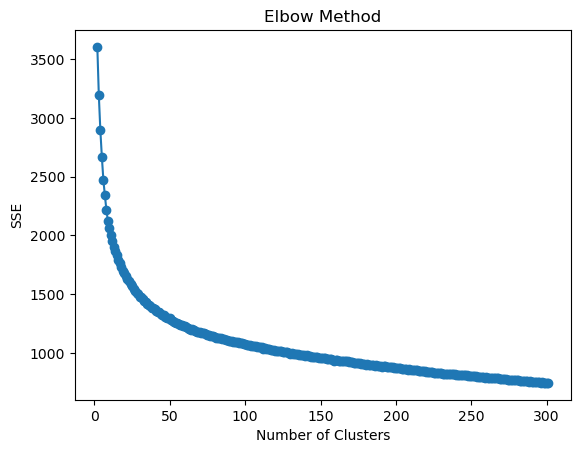

Silhouette Score: 0.1654357480716142
Davies-Bouldin Index: 1.739665664469551
Calinski-Harabasz Index: 362.7466021858113


In [60]:
sse = []
for k in range(2, 302):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(final_features)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 302), sse, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [8]:
# Final Clustering and Metrics
kmeans = KMeans(n_clusters = 8, random_state = seed).fit(final_features)
labels = kmeans.labels_
print("Silhouette Score:", silhouette_score(final_features, labels))
print("Davies-Bouldin Index:", davies_bouldin_score(final_features, labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(final_features, labels))

Silhouette Score: 0.14736198517819404
Davies-Bouldin Index: 1.6855928452801732
Calinski-Harabasz Index: 392.07870574746954


#### Gaussian Mixture Model

In [9]:
gmm        = GaussianMixture(n_components = 11, random_state = seed).fit(final_features)
gmm_labels = gmm.predict(final_features)
print("Silhouette Score:", silhouette_score(final_features, gmm_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(final_features, gmm_labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(final_features, gmm_labels))

Silhouette Score: 0.09833011378295889
Davies-Bouldin Index: 1.9627376027272463
Calinski-Harabasz Index: 285.5556417674899


#### DBSCAN

In [10]:
dbscan        = DBSCAN(eps = 0.5, min_samples = 10).fit(final_features)
dbscan_labels = dbscan.labels_
print("Silhouette Score:", silhouette_score(final_features, dbscan_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(final_features, dbscan_labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(final_features, dbscan_labels))

Silhouette Score: -0.10158244862263133
Davies-Bouldin Index: 2.915047030373817
Calinski-Harabasz Index: 101.56679876933404


## Clustering - Dimensionality Reduction

### PCA

In [11]:
pca        = PCA(n_components = 2)
pca_result = pca.fit_transform(final_features)

#### KMeans

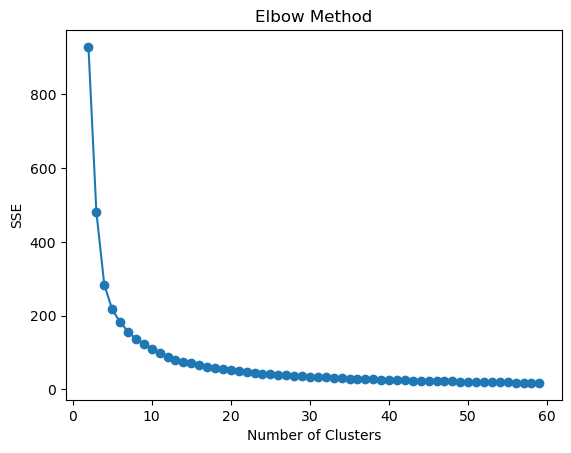

In [12]:
max_clusters = 60

sse = []
for k in range(2, max_clusters):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(pca_result)
    sse.append(kmeans.inertia_)

plt.plot(range(2, max_clusters), sse, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.savefig('plots/clustering_results/1. PCA Elbow.png', dpi = 150, bbox_inches = 'tight')
plt.show()

(PCA + KMeans) Silhouette Score: 0.36957448133547727
(PCA + KMeans) Davies-Bouldin Index: 0.8072985492500686
(PCA + KMeans) Calinski-Harabasz Index: 5184.719672458797


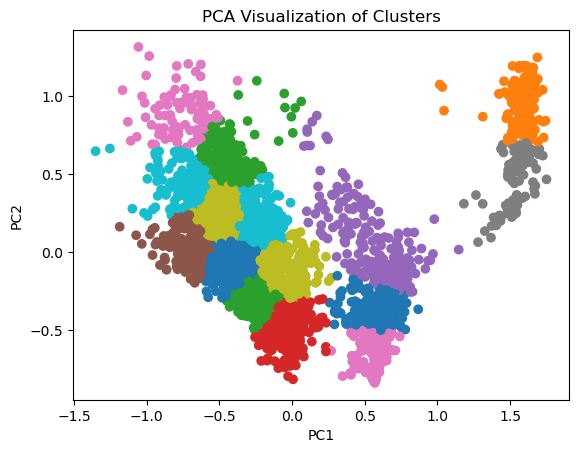

In [13]:
kmeans            = KMeans(n_clusters = 16, random_state = seed).fit(pca_result)
pca_kmeans_labels = kmeans.labels_
print("(PCA + KMeans) Silhouette Score:", silhouette_score(pca_result, pca_kmeans_labels))
print("(PCA + KMeans) Davies-Bouldin Index:", davies_bouldin_score(pca_result, pca_kmeans_labels))
print("(PCA + KMeans) Calinski-Harabasz Index:", calinski_harabasz_score(pca_result, pca_kmeans_labels))

plt.scatter(pca_result[:, 0], pca_result[:, 1], c = pca_kmeans_labels, cmap = 'tab10')
plt.title("PCA Visualization of Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig('plots/clustering_results/1. PCA + KMEANS.png', dpi = 150, bbox_inches = 'tight')
plt.show()

#### Gaussian Mixture Model

(PCA + GMM) Silhouette Score: 0.30164737561859567
(PCA + GMM) Davies-Bouldin Index: 0.9431881892494318
(PCA + GMM) Calinski-Harabasz Index: 3933.7901182631786


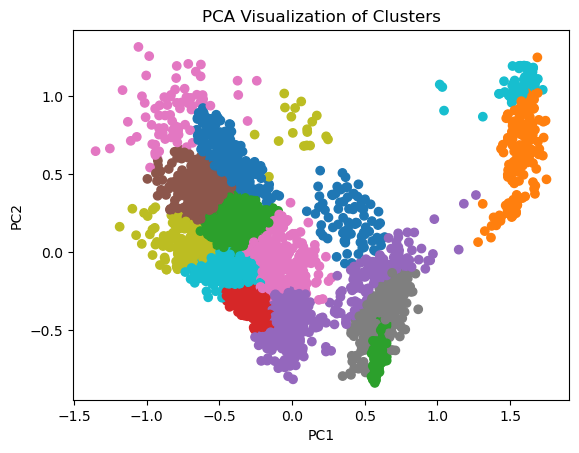

In [14]:
gmm            = GaussianMixture(n_components = 16, random_state = seed).fit(pca_result)
pca_gmm_labels = gmm.predict(pca_result)
print("(PCA + GMM) Silhouette Score:", silhouette_score(pca_result, pca_gmm_labels))
print("(PCA + GMM) Davies-Bouldin Index:", davies_bouldin_score(pca_result, pca_gmm_labels))
print("(PCA + GMM) Calinski-Harabasz Index:", calinski_harabasz_score(pca_result, pca_gmm_labels))

plt.scatter(pca_result[:, 0], pca_result[:, 1], c = pca_gmm_labels, cmap = 'tab10')
plt.title("PCA Visualization of Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig('plots/clustering_results/1. PCA + GMM.png', dpi = 150, bbox_inches = 'tight')
plt.show()

#### DBSCAN

(PCA + DBSCAN) Silhouette Score: -0.18023514384375727
(PCA + DBSCAN) Davies-Bouldin Index: 2.737670608061994
(PCA + DBSCAN) Calinski-Harabasz Index: 46.011603932562956


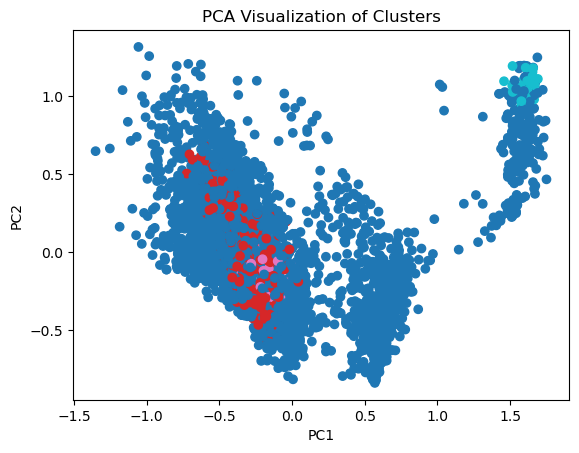

In [15]:
dbscan            = DBSCAN(eps = 0.5, min_samples = 25).fit(final_features)
pca_dbscan_labels = dbscan.labels_
print("(PCA + DBSCAN) Silhouette Score:", silhouette_score(final_features, pca_dbscan_labels))
print("(PCA + DBSCAN) Davies-Bouldin Index:", davies_bouldin_score(final_features, pca_dbscan_labels))
print("(PCA + DBSCAN) Calinski-Harabasz Index:", calinski_harabasz_score(final_features, pca_dbscan_labels))

plt.scatter(pca_result[:, 0], pca_result[:, 1], c = pca_dbscan_labels, cmap = 'tab10')
plt.title("PCA Visualization of Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig('plots/clustering_results/1. PCA + DBSCAN.png', dpi = 150, bbox_inches = 'tight')
plt.show()

### UMAP

In [16]:
reducer   = umap.UMAP()
embedding = reducer.fit_transform(final_features)

#### KMeans

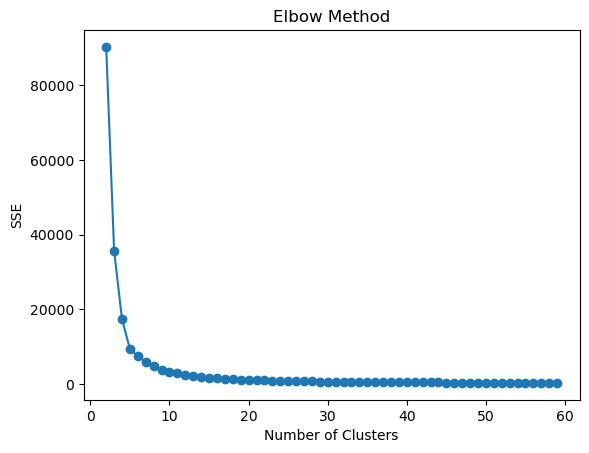

In [17]:
max_clusters = 60

sse = []
for k in range(2, max_clusters):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(embedding)
    sse.append(kmeans.inertia_)

plt.plot(range(2, max_clusters), sse, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.savefig('plots/clustering_results/2. UMAP Elbow.png', dpi = 150, bbox_inches = 'tight')
plt.show()

(UMAP + KMeans) Silhouette Score: 0.54967165
(UMAP + KMeans) Davies-Bouldin Index: 0.5800607844395654
(UMAP + KMeans) Calinski-Harabasz Index: 25628.57508858127


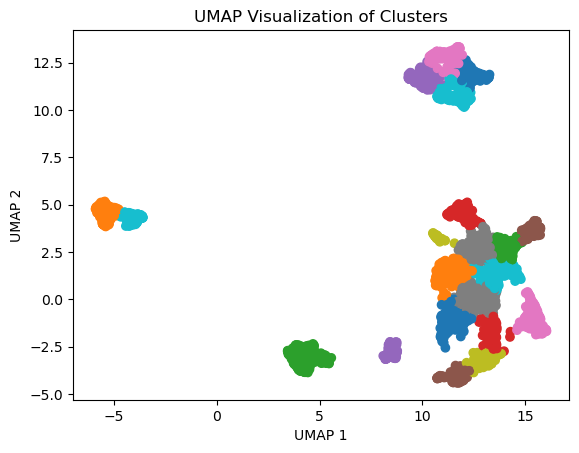

In [18]:
kmeans             = KMeans(n_clusters = 21, random_state = seed).fit(embedding)
umap_kmeans_labels = kmeans.labels_
print("(UMAP + KMeans) Silhouette Score:", silhouette_score(embedding, umap_kmeans_labels))
print("(UMAP + KMeans) Davies-Bouldin Index:", davies_bouldin_score(embedding, umap_kmeans_labels))
print("(UMAP + KMeans) Calinski-Harabasz Index:", calinski_harabasz_score(embedding, umap_kmeans_labels))

plt.scatter(embedding[:, 0], embedding[:, 1], c = umap_kmeans_labels, cmap = 'tab10')
plt.title("UMAP Visualization of Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.savefig('plots/clustering_results/2. UMAP + KMEANS.png', dpi = 150, bbox_inches = 'tight')
plt.show()

#### Gaussian Mixture Model

(UMAP + GMM) Silhouette Score: 0.47927836
(UMAP + GMM) Davies-Bouldin Index: 0.6797164181669719
(UMAP + GMM) Calinski-Harabasz Index: 19106.836334905023


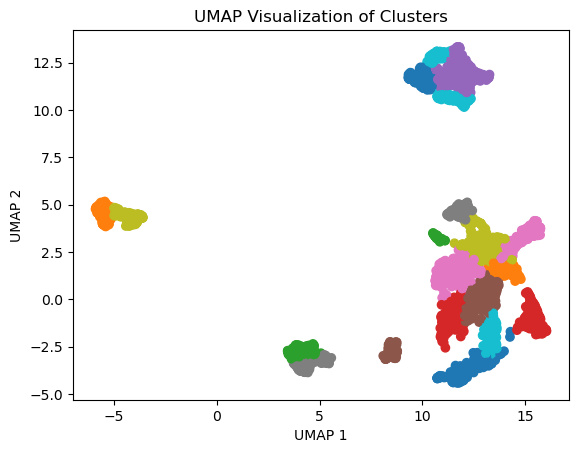

In [19]:
gmm             = GaussianMixture(n_components = 21, random_state = seed).fit(embedding)
uamp_gmm_labels = gmm.predict(embedding)
print("(UMAP + GMM) Silhouette Score:", silhouette_score(embedding, uamp_gmm_labels))
print("(UMAP + GMM) Davies-Bouldin Index:", davies_bouldin_score(embedding, uamp_gmm_labels))
print("(UMAP + GMM) Calinski-Harabasz Index:", calinski_harabasz_score(embedding, uamp_gmm_labels))

plt.scatter(embedding[:, 0], embedding[:, 1], c = uamp_gmm_labels, cmap = 'tab10')
plt.title("UMAP Visualization of Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.savefig('plots/clustering_results/2. UMAP + GMM.png', dpi = 150, bbox_inches = 'tight')
plt.show()

#### DBSCAN

(UMAP + DBSCAN) Silhouette Score: 0.25853786
(UMAP + DBSCAN) Davies-Bouldin Index: 0.6183667647722438
(UMAP + DBSCAN) Calinski-Harabasz Index: 4630.306402347421


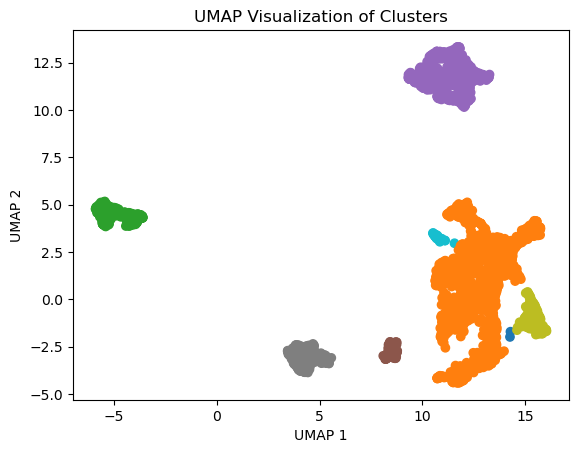

In [20]:
dbscan             = DBSCAN(eps = 0.6, min_samples = 30).fit(embedding)
umap_dbscan_labels = dbscan.labels_
print("(UMAP + DBSCAN) Silhouette Score:", silhouette_score(embedding, umap_dbscan_labels))
print("(UMAP + DBSCAN) Davies-Bouldin Index:", davies_bouldin_score(embedding, umap_dbscan_labels))
print("(UMAP + DBSCAN) Calinski-Harabasz Index:", calinski_harabasz_score(embedding, umap_dbscan_labels))

plt.scatter(embedding[:, 0], embedding[:, 1], c = umap_dbscan_labels, cmap = 'tab10')
plt.title("UMAP Visualization of Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.savefig('plots/clustering_results/2. UMAP + DBSCAN.png', dpi = 150, bbox_inches = 'tight')
plt.show()

### t-SNE

In [21]:
tsne        = TSNE(n_components = 2, random_state = seed)
tsne_result = tsne.fit_transform(final_features)

#### KMeans

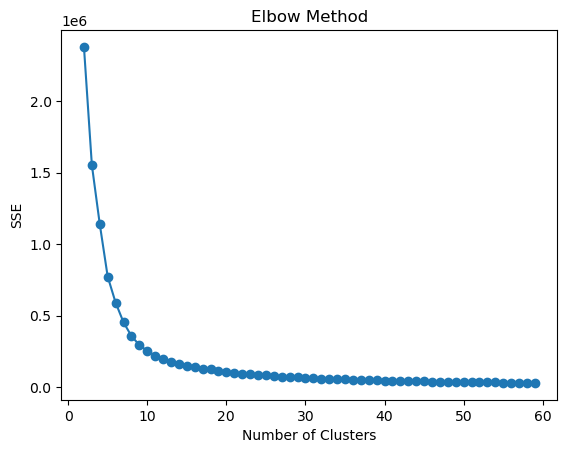

In [22]:
max_clusters = 60

sse = []
for k in range(2, max_clusters):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(tsne_result)
    sse.append(kmeans.inertia_)

plt.plot(range(2, max_clusters), sse, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.savefig('plots/clustering_results/3. TSNE Elbow.png', dpi = 150, bbox_inches = 'tight')
plt.show()

(TSNE + KMeans) Silhouette Score: 0.48492053
(TSNE + KMeans) Davies-Bouldin Index: 0.7106481507963592
(TSNE + KMeans) Calinski-Harabasz Index: 6012.558612072537


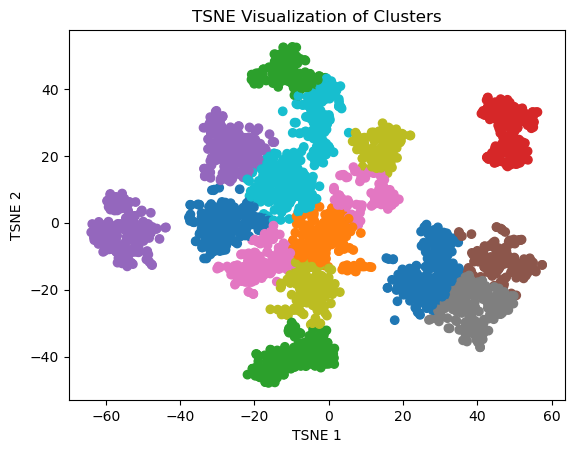

In [23]:
kmeans             = KMeans(n_clusters = 16, random_state = seed).fit(tsne_result)
tsne_kmeans_labels = kmeans.labels_
print("(TSNE + KMeans) Silhouette Score:", silhouette_score(tsne_result, tsne_kmeans_labels))
print("(TSNE + KMeans) Davies-Bouldin Index:", davies_bouldin_score(tsne_result, tsne_kmeans_labels))
print("(TSNE + KMeans) Calinski-Harabasz Index:", calinski_harabasz_score(tsne_result, tsne_kmeans_labels))

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c = tsne_kmeans_labels, cmap = 'tab10')
plt.title("TSNE Visualization of Clusters")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.savefig('plots/clustering_results/3. TSNE + KMeans.png', dpi = 150, bbox_inches = 'tight')
plt.show()

#### Gaussian Mixture Model

(TSNE + GMM) Silhouette Score: 0.440444
(TSNE + GMM) Davies-Bouldin Index: 0.8106493388464735
(TSNE + GMM) Calinski-Harabasz Index: 5102.344872840185


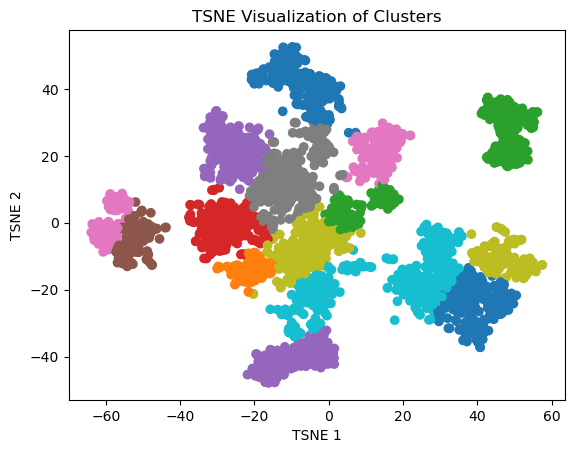

In [24]:
gmm             = GaussianMixture(n_components = 16, random_state = seed).fit(tsne_result)
tsne_gmm_labels = gmm.predict(tsne_result)
print("(TSNE + GMM) Silhouette Score:", silhouette_score(tsne_result, tsne_gmm_labels))
print("(TSNE + GMM) Davies-Bouldin Index:", davies_bouldin_score(tsne_result, tsne_gmm_labels))
print("(TSNE + GMM) Calinski-Harabasz Index:", calinski_harabasz_score(tsne_result, tsne_gmm_labels))

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c = tsne_gmm_labels, cmap = 'tab10')
plt.title("TSNE Visualization of Clusters")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.savefig('plots/clustering_results/3. TSNE + GMM.png', dpi = 150, bbox_inches = 'tight')
plt.show()

#### DBSCAN

(TSNE + DBSCAN) Silhouette Score: -0.015071521
(TSNE + DBSCAN) Davies-Bouldin Index: 0.8129749483660136
(TSNE + DBSCAN) Calinski-Harabasz Index: 509.9934937256035


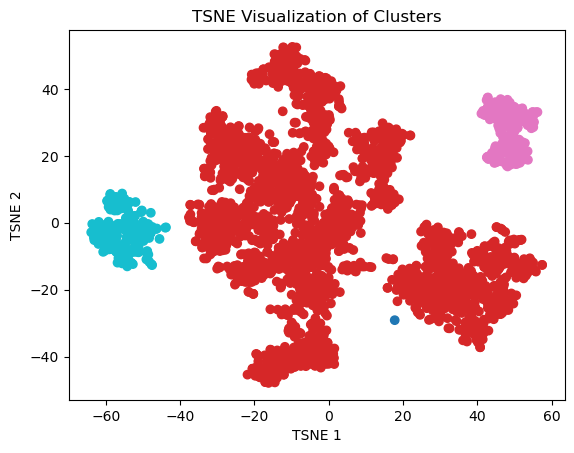

In [25]:
dbscan             = DBSCAN(eps = 5, min_samples = 5).fit(tsne_result)
tsne_dbscan_labels = dbscan.labels_
print("(TSNE + DBSCAN) Silhouette Score:", silhouette_score(tsne_result, tsne_dbscan_labels))
print("(TSNE + DBSCAN) Davies-Bouldin Index:", davies_bouldin_score(tsne_result, tsne_dbscan_labels))
print("(TSNE + DBSCAN) Calinski-Harabasz Index:", calinski_harabasz_score(tsne_result, tsne_dbscan_labels))

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c = tsne_dbscan_labels, cmap = 'tab10')
plt.title("TSNE Visualization of Clusters")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.savefig('plots/clustering_results/3. TSNE + DBSCAN.png', dpi = 150, bbox_inches = 'tight')
plt.show()

## Assign Clusters

In [26]:
clustered_df = pd.DataFrame({'id': df_scaled['Id'].to_numpy(),
                             'umap1': embedding[:, 0],
                             'umap2': embedding[:, 1],
                             'cluster': umap_kmeans_labels
                           })
clustered_df = pd.merge(clustered_df, pd_df, left_on = 'id', right_on = "WyScoutID", how = 'inner')[['id', 'umap1', 'umap2', 'cluster', 'Role']]

clustered_df.head()

,id,umap1,umap2,cluster,Role
0,393228,10.927904,-4.102055,11,CB
1,32793,13.467323,0.092622,14,DM
2,393247,13.477918,-2.047720,7,CB
3,33,-3.646337,4.391579,20,GK
4,36,13.267168,-2.689710,17,CB


## Player Matching

In [27]:
# Empty lists to collect similarity results
top_cosine_ids_list = []
top_eucl_ids_list   = []
top_manh_ids_list   = []
top_knn_ids_list    = []
top_balltree_ids_list = []
top_faiss_ids_list  = []
top_annoy_ids_list  = []
top_hnsw_ids_list   = []

# Process each player
for idx in range(len(clustered_df)):
    player_id      = clustered_df.iloc[idx]['id']
    player_cluster = clustered_df.iloc[idx]['cluster']

    # Subset: players in same cluster
    same_cluster_df       = clustered_df[clustered_df['cluster'] == player_cluster].reset_index(drop = True)
    same_cluster_features = same_cluster_df[['umap1', 'umap2']].values

    # Find player index in this subset
    new_idx = same_cluster_df[same_cluster_df['id'] == player_id].index[0]

    ### --- Traditional Similarities --- ###
    
    # Cosine Similarity
    cos_sim_cluster    = cosine_similarity(same_cluster_features)
    top_cosine_indices = np.argsort(-cos_sim_cluster[new_idx])[1:11]
    top_cosine_ids     = same_cluster_df['id'].iloc[top_cosine_indices].to_list()

    # Euclidean Distance
    eucl_dist_cluster = euclidean_distances(same_cluster_features)
    top_eucl_indices  = np.argsort(eucl_dist_cluster[new_idx])[1:11]
    top_eucl_ids      = same_cluster_df['id'].iloc[top_eucl_indices].to_list()

    # Manhattan Distance
    manh_dist_cluster = manhattan_distances(same_cluster_features)
    top_manh_indices  = np.argsort(manh_dist_cluster[new_idx])[1:11]
    top_manh_ids      = same_cluster_df['id'].iloc[top_manh_indices].to_list()

    ### --- kNN Matching --- ###
    knn              = NearestNeighbors(n_neighbors = min(11, len(same_cluster_df)), metric='euclidean') 
    knn.fit(same_cluster_features)
    _, indices_knn   = knn.kneighbors([same_cluster_features[new_idx]])
    neighbor_ids_knn = same_cluster_df['id'].iloc[indices_knn[0][1:]].to_list()

    ### --- BallTree Matching --- ###
    ball_tree         = BallTree(same_cluster_features, metric = 'euclidean')
    _, indices_ball   = ball_tree.query([same_cluster_features[new_idx]], k = min(11, len(same_cluster_df)))
    neighbor_ids_ball = same_cluster_df['id'].iloc[indices_ball[0][1:]].to_list()

    ### --- FAISS Matching --- ###
    features_faiss     = same_cluster_features.astype('float32')
    faiss_index        = faiss.IndexFlatL2(features_faiss.shape[1])
    faiss_index.add(features_faiss)
    distances_faiss, indices_faiss = faiss_index.search(features_faiss[new_idx:new_idx+1], k=min(11, len(same_cluster_df)))
    neighbor_ids_faiss = same_cluster_df['id'].iloc[indices_faiss[0][1:]].to_list()

    ### --- Annoy Matching --- ###
    dims = same_cluster_features.shape[1]
    annoy_index = AnnoyIndex(dims, metric='euclidean')
    for i, vec in enumerate(same_cluster_features):
        annoy_index.add_item(i, vec)
    annoy_index.build(10)
    indices_annoy      = annoy_index.get_nns_by_item(new_idx, 11)
    neighbor_ids_annoy = same_cluster_df['id'].iloc[[i for i in indices_annoy if i != new_idx][:10]].to_list()

    ### --- HNSW Matching --- ###
    p = hnswlib.Index(space = 'l2', dim = same_cluster_features.shape[1])
    p.init_index(max_elements = same_cluster_features.shape[0], ef_construction = 100, M = 16)
    p.add_items(same_cluster_features)
    labels_hnsw, _     = p.knn_query(same_cluster_features[new_idx:new_idx + 1], k = min(11, len(same_cluster_df)))
    neighbor_ids_hnsw  = same_cluster_df['id'].iloc[labels_hnsw[0][1:]].to_list()

    ### --- Collect results --- ###
    top_cosine_ids_list.append(top_cosine_ids)
    top_eucl_ids_list.append(top_eucl_ids)
    top_manh_ids_list.append(top_manh_ids)
    top_knn_ids_list.append(neighbor_ids_knn)
    top_balltree_ids_list.append(neighbor_ids_ball)
    top_faiss_ids_list.append(neighbor_ids_faiss)
    top_annoy_ids_list.append(neighbor_ids_annoy)
    top_hnsw_ids_list.append(neighbor_ids_hnsw)

# Attach results into clustered_df
clustered_df['top_cosine_ids']   = top_cosine_ids_list
clustered_df['top_eucl_ids']     = top_eucl_ids_list
clustered_df['top_manh_ids']     = top_manh_ids_list
clustered_df['top_knn_ids']      = top_knn_ids_list
clustered_df['top_balltree_ids'] = top_balltree_ids_list
clustered_df['top_faiss_ids']    = top_faiss_ids_list
clustered_df['top_annoy_ids']    = top_annoy_ids_list
clustered_df['top_hnsw_ids']     = top_hnsw_ids_list

clustered_df.head()

,id,umap1,umap2,cluster,Role,top_cosine_ids,top_eucl_ids,top_manh_ids,top_knn_ids,top_balltree_ids,top_faiss_ids,top_annoy_ids,top_hnsw_ids
0,393228,10.927904,-4.102055,11,CB,"[21004, 3644, 134503, 16843, 235450, 26021, 38...","[3644, 85113, 99410, 3885, 146569, 20609, 2100...","[3644, 99410, 85113, 146569, 3885, 101652, 206...","[3644, 85113, 99410, 3885, 146569, 20609, 2100...","[3644, 85113, 99410, 3885, 146569, 20609, 2100...","[3644, 85113, 99410, 3885, 146569, 20609, 2100...","[3644, 85113, 99410, 3885, 146569, 20609, 2100...","[3644, 85113, 99410, 3885, 146569, 20609, 2100..."
1,32793,13.467323,0.092622,14,DM,"[26389, 7873, 70403, 21148, 523089, 367621, 11...","[523089, 21078, 14757, 399673, 397033, 233855,...","[523089, 21078, 14757, 399673, 116345, 397033,...","[523089, 21078, 14757, 399673, 397033, 233855,...","[523089, 21078, 14757, 399673, 397033, 233855,...","[523089, 21078, 14757, 399673, 397033, 233855,...","[523089, 21078, 14757, 399673, 397033, 233855,...","[523089, 21078, 14757, 399673, 397033, 233855,..."
2,393247,13.477918,-2.047720,7,CB,"[14923, 26374, 355937, 3642, 295747, 350569, 7...","[26374, 350569, 295747, 25885, 355937, 7958, 1...","[26374, 350569, 25885, 355937, 295747, 7958, 3...","[26374, 350569, 295747, 25885, 355937, 7958, 1...","[26374, 350569, 295747, 25885, 355937, 7958, 1...","[26374, 350569, 295747, 25885, 355937, 7958, 1...","[26374, 350569, 295747, 25885, 355937, 7958, 1...","[26374, 350569, 295747, 25885, 355937, 7958, 1..."
3,33,-3.646337,4.391579,20,GK,"[149050, 20606, 21128, 190168, 286981, 14794, ...","[190168, 20606, 286981, 149050, 6363, 26971, 2...","[190168, 20606, 286981, 149050, 6363, 26971, 2...","[190168, 20606, 286981, 149050, 6363, 26971, 2...","[190168, 20606, 286981, 149050, 6363, 26971, 2...","[190168, 20606, 286981, 149050, 6363, 26971, 2...","[190168, 20606, 286981, 149050, 6363, 26971, 2...","[190168, 20606, 286981, 149050, 6363, 26971, 2..."
4,36,13.267168,-2.689710,17,CB,"[3573, 86220, 25643, 8360, 40539, 266286, 3010...","[25643, 266286, 301013, 228768, 3573, 40539, 1...","[25643, 266286, 301013, 228768, 3573, 40539, 1...","[25643, 266286, 301013, 228768, 3573, 40539, 1...","[25643, 266286, 301013, 228768, 3573, 40539, 1...","[25643, 266286, 301013, 228768, 3573, 40539, 1...","[25643, 266286, 301013, 228768, 3573, 40539, 1...","[25643, 266286, 301013, 228768, 3573, 40539, 1..."


## Evaluation

#### Expert Knowledge

In [28]:
# Create a dictionary to store precision@10 scores for each method
precision_at_10 = {
    'cosine': [],
    'eucl': [],
    'manh': [],
    'knn': [],
    'balltree': [],
    'faiss': [],
    'annoy': [],
    'hnsw': []
}

# Create a dictionary to store average distance to neighbors for each method
avg_distances = {
    'cosine': [],
    'eucl': [],
    'manh': [],
    'knn': [],
    'balltree': [],
    'faiss': [],
    'annoy': [],
    'hnsw': []
}

# Map from WyScoutID to Role using pd_df
id_to_role = pd_df.set_index('WyScoutID')['Role'].to_dict()

# Neighbor column mapping
neighbor_cols = {
    'cosine': 'top_cosine_ids',
    'eucl': 'top_eucl_ids',
    'manh': 'top_manh_ids',
    'knn': 'top_knn_ids',
    'balltree': 'top_balltree_ids',
    'faiss': 'top_faiss_ids',
    'annoy': 'top_annoy_ids',
    'hnsw': 'top_hnsw_ids'
}

# Calculate precision@10 and average UMAP distance
for idx, row in clustered_df.iterrows():
    player_id   = row['id']
    player_role = row['Role']
    # print(player_role)
    player_vec  = np.array([row['umap1'], row['umap2']])
    
    for key, col in neighbor_cols.items():
        neighbors = row[col]
        # print(neighbors)
        if not isinstance(neighbors, list) or len(neighbors) == 0:
            precision_at_10[key].append(np.nan)
            avg_distances[key].append(np.nan)
            continue
        
        correct_roles = sum(id_to_role.get(nid) == player_role for nid in neighbors)
        precision     = correct_roles / len(neighbors)
        precision_at_10[key].append(precision)
        # print(precision_at_10)
        # print("------")

        neighbor_rows = clustered_df[clustered_df['id'].isin(neighbors)]
        neighbor_vecs = neighbor_rows[['umap1', 'umap2']].values
        if len(neighbor_vecs) == 0:
            avg_distance = np.nan
        else:
            distances = np.linalg.norm(neighbor_vecs - player_vec, axis=1)
            avg_distance = np.mean(distances)
        avg_distances[key].append(avg_distance)

# Append results to clustered_df
for key in neighbor_cols:
    clustered_df[f'precision_at_10_{key}'] = precision_at_10[key]
    clustered_df[f'avg_umap_dist_{key}'] = avg_distances[key]

clustered_df[[f'precision_at_10_{key}' for key in neighbor_cols]].head()

,precision_at_10_cosine,precision_at_10_eucl,precision_at_10_manh,precision_at_10_knn,precision_at_10_balltree,precision_at_10_faiss,precision_at_10_annoy,precision_at_10_hnsw
0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
1,0.3,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


In [38]:
# List of evaluation columns
evaluation_cols = [
    'precision_at_10_eucl', 'avg_umap_dist_eucl',
    'precision_at_10_cosine', 'avg_umap_dist_cosine',
    'precision_at_10_manh', 'avg_umap_dist_manh',
    'precision_at_10_knn', 'avg_umap_dist_knn',
    'precision_at_10_balltree', 'avg_umap_dist_balltree',
    'precision_at_10_faiss', 'avg_umap_dist_faiss',
    'precision_at_10_annoy', 'avg_umap_dist_annoy',
    'precision_at_10_hnsw', 'avg_umap_dist_hnsw'
]

# Calculate mean for each column
average_results = clustered_df[evaluation_cols].mean().round(4)

# Display nicely
for metric, value in average_results.items():
    print(f"{metric}: {value}")

#### Spot-checking

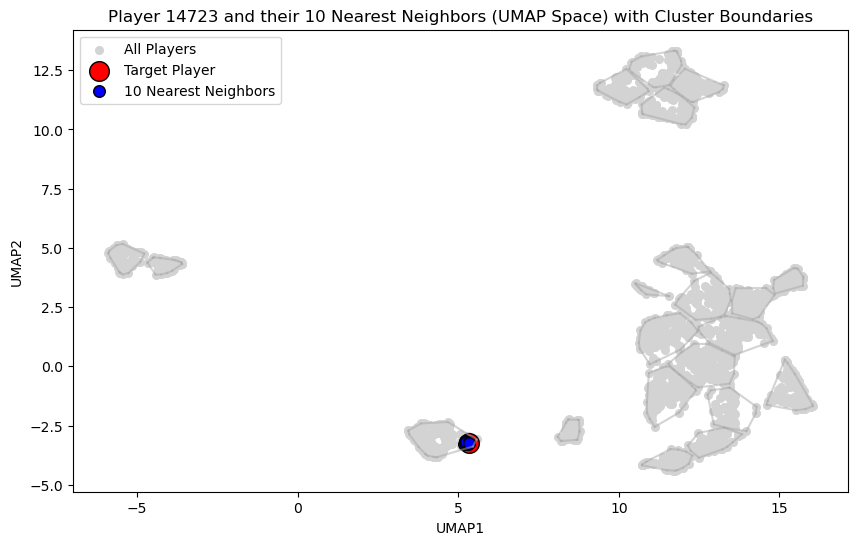

In [30]:
# Target player ID (the actual ID, not the row number!)
target_id = 14723

# Find the row corresponding to that player id
target_row = clustered_df[clustered_df['id'] == target_id].iloc[0]

# Get the list of 10 nearest neighbor IDs
neighbor_ids = target_row['top_knn_ids']

# Get the data for the target player and neighbors
highlight_ids = [target_id] + neighbor_ids
highlight_df  = clustered_df[clustered_df['id'].isin(highlight_ids)]

# Plot the full UMAP
plt.figure(figsize = (10, 6))
plt.scatter(clustered_df['umap1'], clustered_df['umap2'], c = 'lightgray', s = 30, label = 'All Players')

# Draw convex hulls for each cluster
for cluster_id in clustered_df['cluster'].unique():
    cluster_points = clustered_df[clustered_df['cluster'] == cluster_id][['umap1', 'umap2']].values
    if len(cluster_points) >= 3:  # Convex hull needs at least 3 points
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], color = 'darkgray', alpha = 0.5)

plt.scatter(highlight_df['umap1'].iloc[0], highlight_df['umap2'].iloc[0], c = 'red', s = 200, label = 'Target Player', edgecolor = 'black') # Highlight the selected player
plt.scatter(highlight_df['umap1'].iloc[1:], highlight_df['umap2'].iloc[1:], c = 'blue', s = 70, label = '10 Nearest Neighbors', edgecolor = 'black') # Highlight the 10 neighbors

plt.legend()
plt.title(f"Player {target_id} and their 10 Nearest Neighbors (UMAP Space) with Cluster Boundaries")
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.savefig(f'plots/player_similarity_results/{target_id}.png', dpi = 150, bbox_inches = 'tight')
plt.show()

In [31]:
test = clustered_df[clustered_df["id"] == target_id][["id", "top_knn_ids"]]
print(f"ID: {test[['id']].values[0][0]}")
print(f"Nearest Neighbours: {test[['top_knn_ids']].values[0][0]}")

ID: 14723
Nearest Neighbours: [26120, 62389, 70093, 3280, 69968, 26065, 43051, 21350, 8287, 3384]


#### Retrieval quality (Overlap between Methods)

##### Functions

In [32]:
def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)
    if not set1 and not set2:
        return 1.0
    return len(set1 & set2) / len(set1 | set2)

##### Inference

In [33]:
comparison_results = {'cosine_vs_knn': [],
                      'eucl_vs_knn': [],
                      'manh_vs_knn': [],
                      'balltree_vs_knn': [],
                      'faiss_vs_knn': [],
                      'annoy_vs_knn': [],
                      'hnsw_vs_knn': []
                     }

for idx, row in clustered_df.iterrows():
    knn_ids = row['top_knn_ids']

    comparison_results['cosine_vs_knn'].append(jaccard_similarity(row['top_cosine_ids'], knn_ids))
    comparison_results['eucl_vs_knn'].append(jaccard_similarity(row['top_eucl_ids'], knn_ids))
    comparison_results['manh_vs_knn'].append(jaccard_similarity(row['top_manh_ids'], knn_ids))
    comparison_results['balltree_vs_knn'].append(jaccard_similarity(row['top_balltree_ids'], knn_ids))
    comparison_results['faiss_vs_knn'].append(jaccard_similarity(row['top_faiss_ids'], knn_ids))
    comparison_results['annoy_vs_knn'].append(jaccard_similarity(row['top_annoy_ids'], knn_ids))
    comparison_results['hnsw_vs_knn'].append(jaccard_similarity(row['top_hnsw_ids'], knn_ids))

# Convert to DataFrame and summarize
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.mean().sort_values(ascending = False))

eucl_vs_knn        1.000000
faiss_vs_knn       1.000000
balltree_vs_knn    1.000000
hnsw_vs_knn        0.999798
annoy_vs_knn       0.982341
manh_vs_knn        0.850982
cosine_vs_knn      0.279164
dtype: float64


In [35]:
plt.figure(figsize = (10, 6))
sns.boxplot(data = comparison_df)
plt.xticks(rotation = 45)
plt.title('Jaccard Similarity to kNN Neighbors')
plt.ylabel('Jaccard Similarity')
plt.grid(True)
plt.tight_layout()
plt.show()

## Save Final Results

In [53]:
final_df = pd.merge(clustered_df, df_players.to_pandas(), left_on = 'id',
                    right_on = "Id", how = 'inner')[['id', 'firstName', 'lastName', 'full_name',
                                                     'birthDay', 'age',
                                                     'weight', 'height', 'foot',
                                                     'club', 'national_team', 'country_of_birth', 'city_of_birth',
                                                     'position', 'Role_x', 'status',
                                                     'market_value_in_eur', 'highest_market_value_in_eur', 'contract_expiration_date', 'agent_name',
                                                     'image_url',
                                                     'Matches Played',
                                                     'Total Shots', 'Accurate Shots', 'Shot Accuracy', 'Goals', 'Shot Conversion',
                                                     'Penalties Taken', 'Penalties Scored', 'Penalty Conversion',
                                                     'Total Passes', 'Accurate Passes', 'Pass Accuracy', 'Key Passes', 'Assists',
                                                     'Run Attempts With Ball', 'Successful Runs With Ball', 'Perc Successful Runs With Ball',
                                                     'Crosses', 'Dribbles',
                                                     'Free Kick Shots', 'Free Kick Crosses',
                                                     'Aerial Duels', 'Aerial Duels Won', 'Perc Aerial Duels Won',
                                                     'Ground Defensive duels Won', 'Loose Ball Duels', 'Loose Balls Won', 'Perc Loose Balls Won',
                                                     'Sliding Tackles', 'Interceptions', 'Clearances', 'Blocks', 'Possession Regained', 'Own Goals',
                                                     'GK Balls Attacked', 'GK Save Attempts', 'GK Successful Save Attempts', 'Perc GK Save Success',
                                                     'cluster', 'top_knn_ids']]
final_df.rename(columns = {'Role_x': 'role'}, inplace = True)
final_df.columns        = final_df.columns.str.lower().str.replace(' ', '_')
cols = ['shot_accuracy', 'shot_conversion', 'penalty_conversion',
        'pass_accuracy', 'perc_successful_runs_with_ball',
        'perc_aerial_duels_won', 'perc_loose_balls_won',
        'perc_gk_save_success']
for col in cols:
    final_df[col] = (final_df[col] * 100).round(1).astype(str) + '%'
final_df.to_parquet("/mnt/block/data/final_datasets/final_player_df.parquet")